# Multimodal Model – Combining Time-Series, Static Variables, Images, and Text

In this lab, we will explore multimodal models that integrate time-series data, static variables, images, and text, leveraging all the datasets we have used previously.

First, we need to install and import the necessary libraries.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

bookPath = '/content/drive/MyDrive/Colab Notebooks/DL in Banking Book/DeepLearningInBankingBook/TextBook_Lab'

In [34]:
bookPath = '/content/drive/MyDrive/Colab Notebooks/DL in Banking Book/DeepLearningInBankingBook/TextBook_Lab'

In [4]:
# Install necessasary packages, if not done before
!pip install transformers evaluate accelerate hf_xet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# Imports
import numpy as np
import os
import pandas as pd
import random
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
%matplotlib inline

# Import Pytorch lybraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import _LRScheduler

# Huggingface
import transformers
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import pipeline
from transformers import set_seed
from datasets import load_dataset, Dataset, Value, ClassLabel, Features, load_from_disk
import evaluate

## Cleaning Time Series data

Let's start by downloading the time-series dataset from Freddie Mac. This dataset provides monthly loan status updates covering the period from November 2021 to June 2024.

In [2]:
!gdown --fuzzy 'https://drive.google.com/file/d/1cte8MKaSdt3LrqXSUo9oGTe2hnkz8JsU/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=1cte8MKaSdt3LrqXSUo9oGTe2hnkz8JsU
To: /content/Multimodal_Lab_sampled.csv
100% 98.2M/98.2M [00:01<00:00, 84.5MB/s]


In [3]:
# Read the data
df = pd.read_csv('Multimodal_Lab_sampled.csv', low_memory=False)
df

,LOAN_NUMBER,REPORTING_PERIOD,CURRENT_ACTUAL_UPB,CURRENT_LOAN_DELINQUENCY_STATUS,LOAN_AGE,REMAINING_MONTHS,CURRENT_INTEREST_RATE,CURRENT_NON_INTEREST_BEARING_UPB,ESTIMATED_LOAN_TO_VALUE,INTEREST_BEARING_UPB
0,F21Q40000008,202111,68000.00,0,0,360,3.375,0.0,82,68000.00
1,F21Q40000008,202112,68000.00,0,1,359,3.375,0.0,82,68000.00
2,F21Q40000008,202201,68000.00,0,2,358,3.375,0.0,79,68000.00
3,F21Q40000008,202202,68000.00,0,3,357,3.375,0.0,73,68000.00
4,F21Q40000008,202203,68000.00,0,4,356,3.375,0.0,69,68000.00
...,...,...,...,...,...,...,...,...,...,...
1599995,F21Q40674751,202402,356572.31,0,27,333,3.000,0.0,63,356572.31
1599996,F21Q40674751,202403,355884.83,0,28,332,3.000,0.0,61,355884.83
1599997,F21Q40674751,202404,355195.63,0,29,331,3.000,0.0,58,355195.63
1599998,F21Q40674751,202405,354504.71,0,30,330,3.000,0.0,57,354504.71


We assign a value of 1 to loans that were delinquent at least once in the last three months (April to June 2024). Our goal is to predict whether a loan will become delinquent in the next quarter.

In [4]:
# Convert REPORTING_PERIOD to datetime for sorting
df["REPORTING_PERIOD"] = pd.to_datetime(df["REPORTING_PERIOD"], format='%Y%m')

df["CURRENT_LOAN_DELINQUENCY_STATUS"] = pd.to_numeric(df["CURRENT_LOAN_DELINQUENCY_STATUS"], errors='coerce').fillna(1)

# Sort data by Loan Number and Reporting Period (chronological order)
df = df.sort_values(by=["LOAN_NUMBER", "REPORTING_PERIOD"])


# Identify loans that were delinquent at least once in the period 2024-04 to 2024-06
df["CURRENT_LOAN_DELINQUENCY_STATUS"] = (df["CURRENT_LOAN_DELINQUENCY_STATUS"] > 0).astype(int)
mask = (df["REPORTING_PERIOD"] >= "2024-04-01") & (df["REPORTING_PERIOD"] <= "2024-06-30")
df["target"] = df.groupby("LOAN_NUMBER")["CURRENT_LOAN_DELINQUENCY_STATUS"].transform(lambda x: x[mask].max()).astype(int)


# Remove the last three months (April 2024 - June 2024)
df = df[~df["REPORTING_PERIOD"].between(pd.Timestamp("2024-03-31"), pd.Timestamp("2024-06-02"))]
df

,LOAN_NUMBER,REPORTING_PERIOD,CURRENT_ACTUAL_UPB,CURRENT_LOAN_DELINQUENCY_STATUS,LOAN_AGE,REMAINING_MONTHS,CURRENT_INTEREST_RATE,CURRENT_NON_INTEREST_BEARING_UPB,ESTIMATED_LOAN_TO_VALUE,INTEREST_BEARING_UPB,target
0,F21Q40000008,2021-11-01,68000.00,0,0,360,3.375,0.0,82,68000.00,0
1,F21Q40000008,2021-12-01,68000.00,0,1,359,3.375,0.0,82,68000.00,0
2,F21Q40000008,2022-01-01,68000.00,0,2,358,3.375,0.0,79,68000.00,0
3,F21Q40000008,2022-02-01,68000.00,0,3,357,3.375,0.0,73,68000.00,0
4,F21Q40000008,2022-03-01,68000.00,0,4,356,3.375,0.0,69,68000.00,0
...,...,...,...,...,...,...,...,...,...,...,...
1599992,F21Q40674751,2023-11-01,358624.47,0,24,336,3.000,0.0,59,358624.47,0
1599993,F21Q40674751,2023-12-01,357942.12,0,25,335,3.000,0.0,64,357942.12,0
1599994,F21Q40674751,2024-01-01,357258.07,0,26,334,3.000,0.0,64,357258.07,0
1599995,F21Q40674751,2024-02-01,356572.31,0,27,333,3.000,0.0,63,356572.31,0


We normalize the data and One Hot Encode the labels using sklearn's OneHotEncode function. We will also set the class weights as we have done before.

In [5]:
num_cols = [
    "CURRENT_ACTUAL_UPB",
    "LOAN_AGE",
    "REMAINING_MONTHS",
    "CURRENT_INTEREST_RATE",
    "CURRENT_NON_INTEREST_BEARING_UPB",
    "ESTIMATED_LOAN_TO_VALUE",
    "INTEREST_BEARING_UPB",
    "CURRENT_LOAN_DELINQUENCY_STATUS"
]

# Group by loan number for sequence creation
grouped = df.groupby("LOAN_NUMBER")

# Store sequences and targets
X_dict = {}
y_dict = {}

for loan_id, group in grouped:
    group = group.sort_values("REPORTING_PERIOD")  # Sort each loan's time series

    # Extract features as separate sequences
    X_dict[loan_id] = {col: group[col].values for col in num_cols}

    # Assign existing target value (no need to recalculate)
    y_dict[loan_id] = group["target"].iloc[0]



# Perform stratified split
# Convert dictionary to DataFrame
np.random.seed(42)
x_df = pd.DataFrame.from_dict(X_dict, orient="index")

# Map target values from y_dict
x_df["target"] = x_df.index.map(y_dict)

# Perform stratified split
train_idx, test_idx = train_test_split(
    x_df.index, test_size=0.2, stratify=x_df["target"], random_state=42
)

# Assign 'if_test' column based on stratified split
x_df["if_test"] = 0  # Default to training
x_df.loc[test_idx, "if_test"] = 1  # Mark test samples

In [6]:
# Function to scale each feature separately
def scale_dataframe_sequences(x_df, test_var=None):
    scaler = StandardScaler()

    # Split data into train and test
    if test_var is not None:
        x_train = x_df.loc[test_var == 0, :]
        x_test = x_df.loc[test_var == 1, :]
    else:
        x_train = x_df

    scaled_data = {}
    scaled_data_test = {}

    # Get sequence length from first row
    seq_len = len(next(iter(x_train.iloc[0])))

    for column in num_cols:
        # Stack time series data for each loan into a 2D array
        data = np.stack(x_train[column].values).reshape(-1, seq_len)
        if column != "CURRENT_LOAN_DELINQUENCY_STATUS":
          scaled_data[column] = scaler.fit_transform(data).reshape(-1, 1, seq_len).tolist()
        else:
          scaled_data[column] = data.reshape(-1, 1, seq_len).tolist()

        # Scale test set if provided
        if test_var is not None:
            data_test = np.stack(x_test[column].values).reshape(-1, seq_len)
            if column != "CURRENT_LOAN_DELINQUENCY_STATUS":
              scaled_data_test[column] = scaler.transform(data_test).reshape(-1, 1, seq_len).tolist()
            else:
              scaled_data_test[column] = data_test.reshape(-1, 1, seq_len).tolist()

    # Create new DataFrames with scaled data
    scaled_df = pd.DataFrame(scaled_data)
    scaled_df = scaled_df.map(lambda x: np.array(x[0]))

    if test_var is not None:
        scaled_df_test = pd.DataFrame(scaled_data_test)
        scaled_df_test = scaled_df_test.map(lambda x: np.array(x[0]))
        return scaled_df, scaled_df_test
    else:
        return scaled_df, _

# Normalize train and test sets
x_train_val, x_test = scale_dataframe_sequences(x_df[num_cols], x_df["if_test"])

# One-hot encode the target variable
enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
y_train_val = enc.fit_transform(x_df.loc[x_df["if_test"] == 0, "target"].values.reshape(-1, 1))[:, 1]
y_test = enc.transform(x_df.loc[x_df["if_test"] == 1, "target"].values.reshape(-1, 1))[:, 1]

# Compute class weights
pos_weight = np.sum(1 - y_train_val) / np.sum(y_train_val)
pos_weight = torch.tensor(pos_weight, dtype=torch.float32)

In [7]:
x_train_val

,CURRENT_ACTUAL_UPB,LOAN_AGE,REMAINING_MONTHS,CURRENT_INTEREST_RATE,CURRENT_NON_INTEREST_BEARING_UPB,ESTIMATED_LOAN_TO_VALUE,INTEREST_BEARING_UPB,CURRENT_LOAN_DELINQUENCY_STATUS
0,"[-1.516681460523383, -1.5127829987915267, -1.5...","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[0.9752490502682437, 0.9752490502682437, 0.975...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[-0.5309556268594503, -0.18898924307437734, -0...","[-1.516681460523383, -1.5127829987915267, -1.5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[-1.2117159943813423, -1.2073377197258393, -1....","[8.970306299794787, 8.970306299794787, 8.97030...","[0.5418961669107385, 0.5418961669107385, 0.541...","[2.4538508979617175, 2.4538508979617175, 2.453...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[-0.528435227293558, -0.17971444280007412, -0....","[-1.2117159943813423, -1.2073377197258393, -1....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[-0.6295091953829011, -0.6311568523973834, -0....","[-0.11147891349310891, -0.11147891349310925, -...","[-1.9078113217772203, -1.9078113217772203, -1....","[-0.20763242788653533, -0.20763242788653533, -...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[-0.5385168255571272, -0.21217624376013539, -0...","[-0.6295091953829011, -0.6311568523973834, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[-1.1909228944171122, -1.1865119052440878, -1....","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[0.679528680729549, 0.679528680729549, 0.67952...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[-0.5561596225183733, -0.24000064458304507, -0...","[-1.1909228944171122, -1.1865119052440878, -1....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[-0.5671298954902109, -0.5686794089521291, -0....","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[0.679528680729549, 0.679528680729549, 0.67952...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[1.7802507750637893, 4.06350668269365, 4.91506...","[-0.5671298954902109, -0.5686794089521291, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
39995,"[2.0666627666455946, 2.0761990302303004, 2.079...","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[0.08808794165215943, 0.08808794165215943, 0.0...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[1.7802507750637893, 4.06350668269365, -0.0806...","[2.0666627666455946, 2.0761990302303004, 2.079...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
39996,"[2.0458696666813645, 2.055373215748549, 2.0591...","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[0.9752490502682437, 0.9752490502682437, 0.975...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[1.7802507750637893, 4.06350668269365, -0.1191...","[2.0458696666813645, 2.055373215748549, 2.0591...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
39997,"[2.1775592997881548, 2.1872700407996413, 2.191...","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[0.679528680729549, 0.679528680729549, 0.67952...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[1.7802507750637893, 4.06350668269365, -0.3114...","[2.1775592997881548, 2.1872700407996413, 2.191...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
39998,"[-0.44237129570483064, -0.4367825839010368, -0...","[-0.11147891349310891, -0.11147891349310925, -...","[-1.9078113217772203, -1.9078113217772203, -1....","[0.679528680729549, 0.679528680729549, 0.67952...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[1.7802507750637893, 4.06350668269365, -0.1685...","[-0.44237129570483064, -0.4367825839010368, -0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Cleaning static variables

Next, we will clean static features such as credit score, property type, and occupancy status, which were recorded at the time of the loan application.

In [8]:
!gdown --fuzzy 'https://drive.google.com/file/d/1lF1n0Ue-emaflJabOfmQI6CT0D3qAIYK/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=1lF1n0Ue-emaflJabOfmQI6CT0D3qAIYK
To: /content/Multimodal_Lab_Origin_sampled.csv
100% 3.07M/3.07M [00:00<00:00, 22.7MB/s]


In [9]:
# Load filtered static dataset
static_df = pd.read_csv("Multimodal_Lab_Origin_sampled.csv", dtype=str)
static_df

,CREDIT_SCORE,FIRST_TIME_HOMEBUYER,NUMBER_OF_UNITS,OCCUPANCY_STATUS,CLTV,DTI_RATIO,ORIGINAL_UPB,PROPERTY_TYPE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,LOAN_NUMBER,MI_PERCENTAGE,MSA,ZIP3
0,685,N,1,P,80,36,68000,SF,360,1,F21Q40000008,0,23060.0,46800
1,751,N,1,P,80,36,112000,SF,360,2,F21Q40000010,0,45780.0,43500
2,716,N,1,P,80,43,199000,SF,360,2,F21Q40000015,0,NaN,42400
3,706,N,1,P,80,50,196000,PU,180,2,F21Q40000016,0,23060.0,46800
4,720,N,1,P,72,31,115000,SF,360,2,F21Q40000037,0,NaN,74000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,676,N,1,P,80,37,583000,PU,360,4,F21Q40661064,0,47894.0,20100
49996,762,N,1,P,48,40,605000,SF,360,1,F21Q40661065,0,31084.0,91300
49997,688,N,1,P,71,27,212000,SF,360,2,F21Q40661791,0,40340.0,55900
49998,728,N,1,P,80,50,224000,SF,180,2,F21Q40672627,0,NaN,37300


We normalize numeric variables and one-hot encode categorical variables to ensure consistency in the dataset.

In [10]:
# Identify numeric and categorical columns
numeric_cols = ["CREDIT_SCORE", "CLTV", "DTI_RATIO", "ORIGINAL_UPB", "ORIGINAL_LOAN_TERM", "MI_PERCENTAGE"]  # Excluding "NUMBER_OF_BORROWERS"
categorical_cols = ["FIRST_TIME_HOMEBUYER", "OCCUPANCY_STATUS", "PROPERTY_TYPE"]


static_df["ZIP3"] = static_df["ZIP3"].astype(str).str[:-2]
static_df[numeric_cols] = static_df[numeric_cols].astype(float)
static_df["NUMBER_OF_BORROWERS"] = static_df["NUMBER_OF_BORROWERS"].astype(int)

In [11]:
# Add LOAN_NUMBER back before merging
x_df["LOAN_NUMBER"] = x_df.index  # Assign index (loan numbers) back to x_df

# Assign LOAN_NUMBER to train and test sets
loan_numbers_train = x_df.loc[x_df["if_test"] == 0, "LOAN_NUMBER"]
loan_numbers_test = x_df.loc[x_df["if_test"] == 1, "LOAN_NUMBER"]

# Split static data into train and test based on LOAN_NUMBER
static_train_val = static_df[static_df["LOAN_NUMBER"].isin(loan_numbers_train)]
static_test = static_df[static_df["LOAN_NUMBER"].isin(loan_numbers_test)]

# --- SCALE NUMERIC FEATURES ---
scaler = StandardScaler()
static_train_val[numeric_cols] = scaler.fit_transform(static_train_val[numeric_cols])  # Fit on train
static_test[numeric_cols] = scaler.transform(static_test[numeric_cols])  # Apply to test

# --- ONE-HOT ENCODE CATEGORICAL FEATURES ---
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_train = encoder.fit_transform(static_train_val[categorical_cols])  # Fit on train
encoded_test = encoder.transform(static_test[categorical_cols])  # Apply to test

# Convert to DataFrame
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_cols), index=static_train_val.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_cols), index=static_test.index)

<ipython-input-11-fed0006b1390>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  static_train_val[numeric_cols] = scaler.fit_transform(static_train_val[numeric_cols])  # Fit on train
<ipython-input-11-fed0006b1390>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  static_test[numeric_cols] = scaler.transform(static_test[numeric_cols])  # Apply to test


We then merge the cleaned static variables with the time-series table to create a unified dataset for modeling.

In [12]:
# Preserve LOAN_NUMBER and NUMBER_OF_BORROWERS (without scaling)
static_train_final = pd.concat([
    static_train_val[["LOAN_NUMBER", "NUMBER_OF_BORROWERS","MSA","ZIP3"]],  # Keep unscaled
    static_train_val[numeric_cols],  # Already scaled numeric features
    encoded_train_df  # One-hot encoded categorical features
], axis=1)

static_test_final = pd.concat([
    static_test[["LOAN_NUMBER", "NUMBER_OF_BORROWERS","MSA","ZIP3"]],  # Keep unscaled
    static_test[numeric_cols],  # Already scaled numeric features
    encoded_test_df  # One-hot encoded categorical features
], axis=1)

print(f"Processed Train Static Data Shape: {static_train_final.shape}")
print(f"Processed Test Static Data Shape: {static_test_final.shape}")

Processed Train Static Data Shape: (40000, 20)
Processed Test Static Data Shape: (10000, 20)


In [13]:
# Convert index to DataFrame to allow merging
x_train_val = x_train_val.copy()
x_test = x_test.copy()

# Add LOAN_NUMBER column before merging
x_train_val["LOAN_NUMBER"] = loan_numbers_train.values
x_test["LOAN_NUMBER"] = loan_numbers_test.values

# Merge static data with LSTM sequences
x_train_val = x_train_val.merge(static_train_final, on="LOAN_NUMBER", how="left")
x_test = x_test.merge(static_test_final, on="LOAN_NUMBER", how="left")

# Drop LOAN_NUMBER after merging
x_train_val.drop(columns=["LOAN_NUMBER"], inplace=True)
x_test.drop(columns=["LOAN_NUMBER"], inplace=True)

print(f"x_train Shape After Merge: {x_train_val.shape}")
print(f"x_test Shape After Merge: {x_test.shape}")

x_train Shape After Merge: (40000, 27)
x_test Shape After Merge: (10000, 27)


## Merging image dataset

Next, we will merge the image mapping dataset using MSA (Metropolitan Statistical Area) and ZIP3 (the first three digits of the ZIP code) to align LiDAR images with the corresponding loan records.

In [14]:
!gdown --fuzzy 'https://drive.google.com/file/d/1cHLNcnTLdaKtedM_Uz-xmYaXXml0Ws-D/view?usp=sharing'

Downloading...
From (original): https://drive.google.com/uc?id=1cHLNcnTLdaKtedM_Uz-xmYaXXml0Ws-D
From (redirected): https://drive.google.com/uc?id=1cHLNcnTLdaKtedM_Uz-xmYaXXml0Ws-D&confirm=t&uuid=4f3f68f0-8a2a-4f65-8060-585f0a8f07dd
To: /content/usgs_lidar.zip
100% 80.7M/80.7M [00:01<00:00, 52.6MB/s]


In [15]:
!unzip usgs_lidar.zip -d usgs_lidar

Archive:  usgs_lidar.zip
  inflating: usgs_lidar/10180_796_USGS_13_n33w101_20191031.jpg  
  inflating: usgs_lidar/10420_443_USGS_13_n41w082_20230911.jpg  
  inflating: usgs_lidar/10540_973_USGS_13_n45w122_20220426.jpg  
  inflating: usgs_lidar/10740_870_USGS_13_n36w106_20241210.jpg  
  inflating: usgs_lidar/10740_871_USGS_13_n35w108_20240416.jpg  
  inflating: usgs_lidar/10780_713_USGS_13_n31w093_20240207.jpg  
  inflating: usgs_lidar/11020_166_USGS_13_n41w079_20220429.jpg  
  inflating: usgs_lidar/11100_790_USGS_13_n35w104_20210624.jpg  
  inflating: usgs_lidar/11100_791_USGS_13_n36w103_20190916.jpg  
  inflating: usgs_lidar/11244_928_USGS_13_n34w119_20190917.jpg  
  inflating: usgs_lidar/11260_995_USGS_13_n64w154_20190206.jpg  
  inflating: usgs_lidar/11700_288_USGS_13_n36w083_20220512.jpg  
  inflating: usgs_lidar/12060_302_USGS_13_n33w084_20230215.jpg  
  inflating: usgs_lidar/12060_303_USGS_13_n34w085_20230215.jpg  
  inflating: usgs_lidar/12060_306_USGS_13_n34w084_20230215.jpg  


In [16]:
!gdown --fuzzy 'https://drive.google.com/file/d/1QyzNtHVurvrXvHG1j2oeq7rwfC6vnA1h/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=1QyzNtHVurvrXvHG1j2oeq7rwfC6vnA1h
To: /content/msa_zip3_mapping_cleaned.csv
100% 109k/109k [00:00<00:00, 3.07MB/s]


In [17]:
image_df = pd.read_csv('msa_zip3_mapping_cleaned.csv', dtype=str)
image_df

,MSA,ZIP3,LiDAR_File
0,NaN,812,usgs_lidar/nan_812_USGS_13_n38w105_20230602.jpg
1,41180.0,631,usgs_lidar/41180_631_USGS_13_n39w091_20240228.jpg
2,15764.0,21,usgs_lidar/15764_021_USGS_13_n43w072_20240130.jpg
3,NaN,467,usgs_lidar/nan_467_USGS_13_n41w085_20230717.jpg
4,23060.0,468,usgs_lidar/nan_467_USGS_13_n41w085_20230717.jpg
...,...,...,...
1852,46060.0,853,usgs_lidar/38060_851_USGS_13_n33w113_20241016.jpg
1853,12060.0,307,usgs_lidar/17420_373_USGS_13_n35w085_20230215.jpg
1854,16020.0,629,usgs_lidar/nan_628_USGS_13_n38w090_20240228.jpg
1855,NaN,851,usgs_lidar/38060_851_USGS_13_n33w113_20241016.jpg


In [18]:
# Merge static data with LSTM sequences
x_train_val = x_train_val.merge(image_df, on=["MSA","ZIP3"], how="left")
x_test = x_test.merge(image_df, on=["MSA","ZIP3"], how="left")

# Drop LOAN_NUMBER after merging
x_train_val.drop(columns=["MSA", "ZIP3"], inplace=True)
x_test.drop(columns=["MSA", "ZIP3"], inplace=True)

Finally, we have established a comprehensive dataset that integrates time-series data, static variables, and image mapping, providing a unified foundation for our multimodal analysis.

In [19]:
x_train_val

,CURRENT_ACTUAL_UPB,LOAN_AGE,REMAINING_MONTHS,CURRENT_INTEREST_RATE,CURRENT_NON_INTEREST_BEARING_UPB,ESTIMATED_LOAN_TO_VALUE,INTEREST_BEARING_UPB,CURRENT_LOAN_DELINQUENCY_STATUS,NUMBER_OF_BORROWERS,CREDIT_SCORE,...,FIRST_TIME_HOMEBUYER_Y,OCCUPANCY_STATUS_I,OCCUPANCY_STATUS_P,OCCUPANCY_STATUS_S,PROPERTY_TYPE_CO,PROPERTY_TYPE_CP,PROPERTY_TYPE_MH,PROPERTY_TYPE_PU,PROPERTY_TYPE_SF,LiDAR_File
0,"[-1.516681460523383, -1.5127829987915267, -1.5...","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[0.9752490502682437, 0.9752490502682437, 0.975...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[-0.5309556268594503, -0.18898924307437734, -0...","[-1.516681460523383, -1.5127829987915267, -1.5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,-0.520106,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,usgs_lidar/nan_467_USGS_13_n41w085_20230717.jpg
1,"[-1.2117159943813423, -1.2073377197258393, -1....","[8.970306299794787, 8.970306299794787, 8.97030...","[0.5418961669107385, 0.5418961669107385, 0.541...","[2.4538508979617175, 2.4538508979617175, 2.453...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[-0.528435227293558, -0.17971444280007412, -0....","[-1.2117159943813423, -1.2073377197258393, -1....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,0.019259,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,usgs_lidar/45780_435_USGS_13_n42w084_20230717.jpg
2,"[-0.6295091953829011, -0.6311568523973834, -0....","[-0.11147891349310891, -0.11147891349310925, -...","[-1.9078113217772203, -1.9078113217772203, -1....","[-0.20763242788653533, -0.20763242788653533, -...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[-0.5385168255571272, -0.21217624376013539, -0...","[-0.6295091953829011, -0.6311568523973834, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,-0.348490,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,usgs_lidar/nan_467_USGS_13_n41w085_20230717.jpg
3,"[-1.1909228944171122, -1.1865119052440878, -1....","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[0.679528680729549, 0.679528680729549, 0.67952...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[-0.5561596225183733, -0.24000064458304507, -0...","[-1.1909228944171122, -1.1865119052440878, -1....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,-0.234079,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,usgs_lidar/nan_740_USGS_13_n36w096_20250102.jpg
4,"[-0.5671298954902109, -0.5686794089521291, -0....","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[0.679528680729549, 0.679528680729549, 0.67952...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[1.7802507750637893, 4.06350668269365, 4.91506...","[-0.5671298954902109, -0.5686794089521291, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,-0.765271,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,usgs_lidar/nan_730_USGS_13_n35w097_20250102.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,"[2.0666627666455946, 2.0761990302303004, 2.079...","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[0.08808794165215943, 0.08808794165215943, 0.0...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[1.7802507750637893, 4.06350668269365, -0.0806...","[2.0666627666455946, 2.0761990302303004, 2.079...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0.109153,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,usgs_lidar/35084_183_USGS_13_n42w075_20240925.jpg
39996,"[2.0458696666813645, 2.055373215748549, 2.0591...","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[0.9752490502682437, 0.9752490502682437, 0.975...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[1.7802507750637893, 4.06350668269365, -0.1191...","[2.0458696666813645, 2.055373215748549, 2.0591...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

##  Get fixed textual data

We will use the most recent Federal Reserve speech from March 2024 as the fixed textual data for our analysis.

**Scenario**:

You are a data scientist at a bank, analyzing loan risk. After watching the Federal Reserve speech from March 2024, you aim to leverage multiple datasets—including time-series data from the loan dataset, static features from loan applications, LiDAR images, and the FED speech—to predict whether a loan will become delinquent in the next quarter.

In [20]:
!gdown --fuzzy 'https://drive.google.com/file/d/1uVt9BC2tgr-MWrFZvYvA_I8IzTabNZtL/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=1uVt9BC2tgr-MWrFZvYvA_I8IzTabNZtL
To: /content/fed_speeches.csv
100% 49.5M/49.5M [00:00<00:00, 77.3MB/s]


In [21]:
fed_speech = pd.read_csv("/content/fed_speeches.csv", delimiter=",", on_bad_lines="skip", engine="python")

In [22]:
# Create year and month columns
fed_speech['date'] = pd.to_datetime(fed_speech['date'], errors='coerce')
fed_speech["year"] = fed_speech["date"].dt.year  # Extract year
fed_speech["month"] = fed_speech["date"].dt.month  # Extract month
fed_speech

,date,text,year,month
0,1996-12-19,Ms. Rivlin discusses the prudential regulation...,1996,12
1,1997-04-24,Mr. Meyer discusses the economic outlook and t...,1997,4
2,1997-12-15,"Mr. Kelley discusses the ""Millennium Bug"" from...",1997,12
3,1997-12-02,Mr. Greenspan's remarks to the Economic Club o...,1997,12
4,1997-11-17,Mr. McDonough gives a US perspective on Econom...,1997,11
...,...,...,...,...
2458,2024-11-14,Jerome H Powell: Economic outlook\nSpeech by M...,2024,11
2459,2024-11-20,Michelle W Bowman: Approaching policymaking pr...,2024,11
2460,2024-11-14,For release on delivery\n7:00 a.m. EST (9:00 a...,2024,11
2461,2024-12-03,Adriana D Kugler: A year in review - a tale of...,2024,12


In [23]:
fed_speech[(fed_speech.year == 2024) & (fed_speech.month == 3)]

,date,text,year,month
2361,2024-03-06,Jerome H Powell: Semiannual Monetary Policy Re...,2024,3
2362,2024-03-05,For release on delivery\n6:45 p.m. EST\nMarch ...,2024,3
2363,2024-03-01,For release on delivery\n3:20 p.m. EST (12:20 ...,2024,3
2364,2024-03-01,For release on delivery\n10:15 am. EST\nMarch ...,2024,3
2368,2024-03-07,Michelle W Bowman: Reflections on the economy ...,2024,3
2369,2024-03-25,For release on delivery\n10:30 a.m. EDT\nMarch...,2024,3
2370,2024-03-27,Christopher J Waller: There's still no rush\nS...,2024,3


In [24]:
## taking the most recent speech
fixed_fed_speech = fed_speech[(fed_speech.year == 2024) & (fed_speech.month == 3)]["text"].values[-1]

In this step, we preprocess the speech text by **tokenizing, removing stopwords, and eliminating punctuation** to prepare the data for further analysis.

In [25]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words("english"))


def clean_text(text):
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize text
    table = str.maketrans('', '', string.punctuation)  # Create a table for removing punctuation
    filtered_tokens = [
        token.translate(table) for token in tokens
        if token.isalnum() and token not in stop_words  # Remove stop words here!
    ]
    cleaned_text = ' '.join(filtered_tokens)
    return cleaned_text

fixed_fed_speech = clean_text(fixed_fed_speech)
fixed_fed_speech

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


'christopher j waller still rush speech mr christopher j waller member board governors federal reserve system economic club new york new york city 27 march 2024 1 thank barbara thank opportunity speak today subject often outlook economy affects federal open market committee fomc continuing effort reduce inflation sustained level 2 percent maintaining healthy labor market made lot headway toward inflation goal 2023 labor market moved substantially better balance holding unemployment rate 4 percent nearly two years data received far year made uncertain speed continued progress back february noted data fourth quarter gross domestic product gdp well january data job growth inflation came hotter expected concluded needed time verify progress inflation saw second half 2023 would continue meant rush begin cutting interest rates normalize stance monetary policy past month additional economic data reinforced view february job gains moved back making average strong various inflation measures con

## Preparing Dataloader for multimodal model

We create a **`Multimodal Dataset Class`**, integrating time-series data, static features, LiDAR images, and textual data.

In [26]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import cv2

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
fixed_tokens = tokenizer(fixed_fed_speech, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
fixed_tokens = {key: val.squeeze(0) for key, val in fixed_tokens.items()}  # Store as dict

class MultimodalDataset(Dataset):
    def __init__(self, dataframe, y_values):
        """
        dataframe  : DataFrame containing time series, static variables, and LiDAR file paths
        fixed_text : Single fixed text string (e.g., FED speech that applies to all)
        tokenizer  : Transformer tokenizer for text processing
        max_length : Max token length for text processing
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.y_values = torch.tensor(y_values, dtype=torch.float32)  # Ensure target is float32


        # Define image transformation
        self.normalize_transform = transforms.Normalize(mean=[0.5], std=[0.5])


        # Identify column indices for time-series and static variables
        self.time_series_start = 0
        self.time_series_end = 8
        self.static_start = 8
        self.static_end = -1


        # Define image loading. We use CV2 for faster loading
    def load_image(self, image_path):
        """Load and preprocess image using OpenCV for speed."""
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        image = cv2.resize(image, (224, 224))  # Resize
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0  # Normalize 0-1
        return self.normalize_transform(image)



    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        #  Ensure time-series to tensor
        time_series = torch.tensor(
            np.array(row.iloc[self.time_series_start:self.time_series_end].tolist()),
            dtype=torch.float32
        )


        # Static variable to tensor
        static_features = torch.tensor(
            np.array(row.iloc[self.static_start:self.static_end].astype(float).values.tolist()),
            dtype=torch.float32
        )

        # Load LiDAR image (grayscale)
        image = self.load_image(row["LiDAR_File"])

        # Expand fixed text tokens to match batch size
        batch_text_tokens = fixed_tokens

        # Retrieve target
        target = self.y_values[idx]

        # Return dictionary (use precomputed text for all samples)
        return {
            "time_series": time_series,
            "static_features": static_features,
            "image_data": image,
            "text_data": batch_text_tokens,
            "target": target
        }

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

This code splits the dataset, creates PyTorch dataset instances, and prepares data loaders for training, validation, and testing in a multimodal deep learning model.

In [27]:
def worker_init_fn(worker_id):
    """Ensure each worker has a different seed based on global seed."""
    seed = SEED + worker_id
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

In [28]:
from sklearn.model_selection import train_test_split

# Train-val split
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.33, random_state=42, stratify=y_train_val)


SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU
np.random.seed(SEED)
random.seed(SEED)

# Create dataset instances (pass y_train & y_test separately)
train_dataset = MultimodalDataset(x_train, y_train)
val_dataset = MultimodalDataset(x_val, y_val)
test_dataset = MultimodalDataset(x_test, y_test)

# Create PyTorch DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2,
                          worker_init_fn=worker_init_fn, pin_memory=True, persistent_workers=True, prefetch_factor=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Check batch structure
batch = next(iter(train_loader))
print(f"Time-series data shape: {batch['time_series'].shape}")  # (batch_size, num_features, seq_length)
print(f"Static feature shape: {batch['static_features'].shape}")  # (batch_size, num_static_features)
print(f"Text input IDs shape: {batch['text_data']['input_ids'].shape}")  # (batch_size, max_length)
print(f"Image data shape: {batch['image_data'].shape}")  # (batch_size, 1, 256, 256)
print(f"Target shape: {batch['target'].shape}")  # (batch_size,)

Time-series data shape: torch.Size([128, 8, 29])
Static feature shape: torch.Size([128, 17])
Text input IDs shape: torch.Size([128, 512])
Image data shape: torch.Size([128, 1, 224, 224])
Target shape: torch.Size([128])


## Multimodal deep learning model - intermediate fusion

In this section, we will build a multimodal deep learning model that integrates four distinct data modalities:


*   Time Series Data: Loan performance history over time with Transformer Encoder.
*   Static Features: Borrower information, property details, and loan
*   LiDAR Images: LiDAR images processed using a CNN.
*   Textual Data: Federal Reserve speeches analyzed with DistilBERT.


To predict whether a loan will become delinquent in the following quarter, we will utilize a combination of Transformers for time-series data, CNNs for image processing, and a fusion layer to integrate information from all modalities effectively.

In [29]:
import math
from transformers import DistilBertModel

### Positional Encoding Module
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + 0.1 * self.pe[:, :x.size(1), :]

### Time-Series Transformer Encoder with Positional Encoding
class TimeSeriesModel(nn.Module):
    def __init__(self, num_time_series_features, seq_length, dropout=0.1):
        super(TimeSeriesModel, self).__init__()

        self.proj = nn.Linear(num_time_series_features, 64)
        self.positional_encoding = PositionalEncoding(embed_dim=64, max_len=seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=4, dim_feedforward=128, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.fc = nn.Sequential(
            nn.Linear(seq_length * 64, 128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.proj(x)
        x = self.positional_encoding(x)
        x = self.transformer(x)
        x = x.reshape(x.shape[0], -1)
        return self.fc(x)

### CNN Model for LiDAR Images (BatchNorm + Dropout)
class LiDARCNN(nn.Module):
    def __init__(self, dropout=0.3):
        super(LiDARCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

### Multimodal Model
class MultimodalDelinquencyModel(nn.Module):
    def __init__(self, num_time_series_features, seq_length, num_static_features, dropout=0.3):
        super(MultimodalDelinquencyModel, self).__init__()

        ### Time-Series Component (Transformer-Based with Positional Encoding)
        self.time_series_model = TimeSeriesModel(num_time_series_features, seq_length, dropout)

        ### Static Features Component (MLP)
        self.static_fc = nn.Sequential(
            nn.Linear(num_static_features, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        ### Text Component (DistilBERT)
        self.text_model = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.text_fc = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        ### LiDAR Image Component (CNN)
        self.image_model = LiDARCNN(dropout)

        ### Fusion Layer
        self.fusion_layer = nn.Sequential(
            nn.Linear(128 + 128 + 128 + 128, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, time_series, static_features, text_inputs, image_data):
        ### Time-Series Processing
        time_series_out = self.time_series_model(time_series)

        ### Static Feature Processing
        static_out = self.static_fc(static_features)

        ### Text Processing (DistilBERT)
        text_out = self.text_model(**text_inputs).last_hidden_state[:, 0, :]
        text_out = self.text_fc(text_out)

        ### LiDAR Image Processing (CNN)
        image_out = self.image_model(image_data)

        ### Fusion
        fused = torch.cat([time_series_out, static_out, text_out, image_out], dim=1)
        output = self.fusion_layer(fused)

        return output  # Raw logits (for BCEWithLogitsLoss)


Now, let's begin training our multimodal deep learning model! Given its complexity, training may take some time.  

To improve efficiency, we are leveraging **mixed precision training** with `torch.amp.GradScaler`, which accelerates computations while reducing memory consumption.


In [30]:
from sklearn.metrics import classification_report

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU
np.random.seed(SEED)
random.seed(SEED)


# Initialize model
num_time_series_features = 8
seq_length = len(x_train.iloc[0, 0])  # Adjust based on your time-series length
num_static_features = len(x_train.iloc[0, 8:-1])  # Adjust based on your dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalDelinquencyModel(num_time_series_features, seq_length, num_static_features, dropout=0.3).to(device)

# Loss function & optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)  # Using BCEWithLogitsLoss
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

# Mixed Precision Training (AMP)
scaler = torch.amp.GradScaler('cuda')

# Best validation loss tracking
best_val_loss = float("inf")
checkpoint_path = "best_multimodal_model.pth"


### Training Function with Validation
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    global best_val_loss
    model.train()

    for epoch in range(num_epochs):
        total_train_loss = 0
        total_correct = 0
        total_samples = 0

        ### Training Loop
        for batch in train_loader:
            optimizer.zero_grad()

            # Move data to GPU
            time_series = batch["time_series"].to(device)
            static_features = batch["static_features"].to(device)
            image_data = batch["image_data"].to(device)
            text_inputs = {key: val.to(device) for key, val in batch["text_data"].items()}
            targets = batch["target"].to(device)

            with torch.amp.autocast('cuda'):  # Mixed Precision Training
                outputs = model(time_series, static_features, text_inputs, image_data).squeeze()
                loss = criterion(outputs, targets.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += loss.detach()  # Reduce unnecessary GPU sync

            # Convert logits to probabilities for accuracy calculation
            probs = torch.sigmoid(outputs)
            predictions = (probs > 0.5).float()
            total_correct += (predictions == targets).sum()
            total_samples += targets.size(0)

        train_acc = 100 * total_correct.cpu().item() / total_samples
        avg_train_loss = total_train_loss.item() / len(train_loader)

        ### Validation Loop
        model.eval()
        total_val_loss = 0
        correct, total = 0, 0

        with torch.no_grad():
            for batch in val_loader:
                time_series = batch["time_series"].to(device)
                static_features = batch["static_features"].to(device)
                image_data = batch["image_data"].to(device)
                text_inputs = {key: val.to(device) for key, val in batch["text_data"].items()}
                targets = batch["target"].to(device)

                outputs = model(time_series, static_features, text_inputs, image_data).squeeze()
                loss = criterion(outputs, targets.float())
                total_val_loss += loss.detach()

                # Convert logits to probabilities for accuracy calculation
                probs = torch.sigmoid(outputs)
                predictions = (probs > 0.5).float()
                correct += (predictions == targets).sum()
                total += targets.size(0)

        val_acc = 100 * correct.cpu().item() / total
        avg_val_loss = total_val_loss.item() / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        ### Save best model checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Best model saved at epoch {epoch+1} with val loss: {avg_val_loss:.4f}")

    print("Training Complete!")

### One epoch takes 1.5 min with A100
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1/10 | Train Loss: 1.3507 | Train Acc: 62.51% | Val Loss: 1.3119 | Val Acc: 60.06%
Best model saved at epoch 1 with val loss: 1.3119
Epoch 2/10 | Train Loss: 1.2499 | Train Acc: 69.28% | Val Loss: 1.2311 | Val Acc: 71.58%
Best model saved at epoch 2 with val loss: 1.2311
Epoch 3/10 | Train Loss: 1.1271 | Train Acc: 76.03% | Val Loss: 1.1392 | Val Acc: 84.08%
Best model saved at epoch 3 with val loss: 1.1392
Epoch 4/10 | Train Loss: 0.9886 | Train Acc: 83.39% | Val Loss: 0.9935 | Val Acc: 86.03%
Best model saved at epoch 4 with val loss: 0.9935
Epoch 5/10 | Train Loss: 0.8611 | Train Acc: 88.99% | Val Loss: 0.8942 | Val Acc: 91.14%
Best model saved at epoch 5 with val loss: 0.8942
Epoch 6/10 | Train Loss: 0.7841 | Train Acc: 92.34% | Val Loss: 0.8647 | Val Acc: 91.98%
Best model saved at epoch 6 with val loss: 0.8647
Epoch 7/10 | Train Loss: 0.7478 | Train Acc: 92.47% | Val Loss: 0.8658 | Val Acc: 94.97%
Epoch 8/10 | Train Loss: 0.7306 | Train Acc: 93.09% | Val Loss: 0.8417 | Val 

Training takes approximately **15 minutes**. However, we observe that further training may be beneficial, as the validation loss continues to decrease.


Now, let's proceed with evaluating the model.

In [31]:
### Model Evaluation Function
def evaluate_model(model, test_loader, device):
    """
    Evaluates the model and plots the confusion matrix (normalized) and ROC curve.

    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader with test samples.
        device: Device (cuda or cpu).

    Returns:
        all_labels, all_preds, all_probs
    """
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            # Move data to device
            time_series = batch["time_series"].to(device)
            static_features = batch["static_features"].to(device)
            text_inputs = {key: val.to(device) for key, val in batch["text_data"].items()}
            image_data = batch["image_data"].to(device)
            targets = batch["target"].to(device)

            # Forward pass (raw logits)
            logits = model(time_series, static_features, text_inputs, image_data).squeeze()

            # Convert logits to probabilities using Sigmoid
            probs = torch.sigmoid(logits).cpu().numpy()

            # Store results
            all_probs.extend(probs)
            all_labels.extend(targets.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Compute binary predictions based on threshold 0.5
    all_preds = (all_probs >= 0.5).astype(int)

    return all_labels, all_preds, all_probs

In [32]:
# Load the best model
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
print("Loaded best model for evaluation!")

# Evaluate on test data
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device)

Loaded best model for evaluation!


Our model performs pretty well!

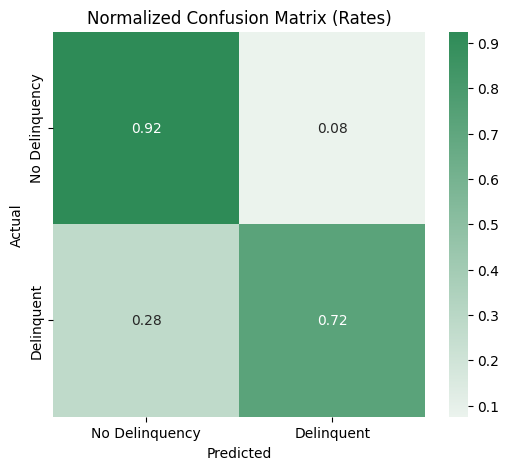

In [40]:
### Confusion Matrix (Normalized)
cm = confusion_matrix(all_labels, all_preds)
cm_rates = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rates, annot=True, fmt=".2f", cmap=sns.light_palette("seagreen", as_cmap=True),
                xticklabels=["No Delinquency", "Delinquent"],
                yticklabels=["No Delinquency", "Delinquent"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix (Rates)")
plt.savefig(os.path.join(bookPath, "multimodal_confusion_matrix.pdf"))
plt.show()

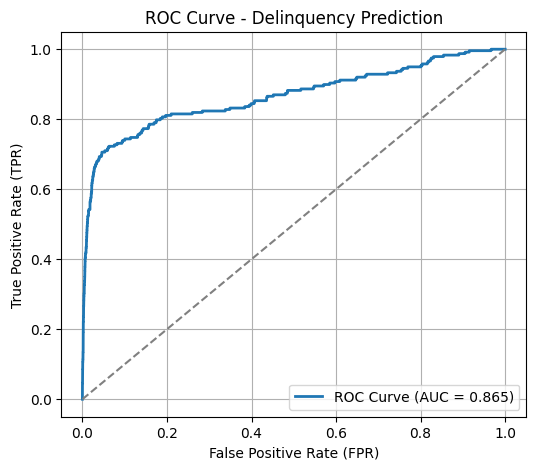

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9927    0.9245    0.9574      9762
         1.0     0.1892    0.7227    0.2999       238

    accuracy                         0.9197     10000
   macro avg     0.5910    0.8236    0.6287     10000
weighted avg     0.9736    0.9197    0.9418     10000



In [41]:
### ROC Curve & AUC Score
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal reference line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Delinquency Prediction")
plt.legend(loc=4)
plt.grid()
plt.savefig(os.path.join(bookPath, "multimodal_roc_curves.pdf"))
plt.show()

### Classification Report
print("Classification Report:\n", classification_report(all_labels, all_preds, digits=4))

## Multimodal model with cross-attention

In this section, we implement a multimodal deep learning model that integrates information from multiple data sources using cross-attention mechanisms. Unlike traditional models that process different modalities independently, cross-attention allows the model to dynamically learn relationships between feature representations, improving predictive performance.

### Model Architecture

Our model processes four distinct modalities:

*  Time-Series Data: Loan performance over time, modeled using a Transformer with positional encoding.
*  Static Features: Borrower and loan characteristics, processed through a Multi-Layer Perceptron (MLP).
*  Text Data: Federal Reserve speeches, encoded using DistilBERT.
*  LiDAR Images: Spatial features extracted via a CNN.


To enhance feature interactions, cross-attention is applied at multiple levels:

*  Text ↔ Time-Series: Captures relationships between Federal Reserve statements and historical loan performance.
*  Static Features ↔ LiDAR Images: Links borrower characteristics with geographic-based insights.
*  Time-Series ↔ Static Features: Models how borrower attributes influence loan behavior over time.

### Fusion Strategy

After applying cross-attention, the model undergoes two levels of feature refinement:

*  Second-Level Cross-Attention: Further interactions between attended representations from different modalities.
*  Weighted Fusion Mechanism: A learnable attention-based fusion layer assigns adaptive importance to each attended feature representation before making a final prediction.
*  The fused representation is then passed through a fully connected prediction layer to estimate loan delinquency status.

In [42]:
from transformers import DistilBertModel
import math

### Cross-Attention Module
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=4, dropout=0.1):
        super(CrossAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout)
        self.gate = nn.Linear(embed_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()
        self.scale = nn.Parameter(torch.ones(1))  # Learnable scaling factor
        self.norm = nn.LayerNorm(embed_dim)  # Layer normalization

    def forward(self, x1, x2):
        """
        Cross-Attention between two modalities.
        Args:
            x1 (tensor): Query features (batch, feature_dim).
            x2 (tensor): Key and Value features (batch, feature_dim).
        Returns:
            tensor: Attended feature representation.
        """
        gate_value = self.sigmoid(self.gate(torch.cat([x1, x2], dim=-1)))  # Compute gate
        attn_output, _ = self.attention(x1.unsqueeze(0), x2.unsqueeze(0), x2.unsqueeze(0))
        return self.norm(self.scale * (gate_value * attn_output.squeeze(0) + (1 - gate_value) * x1))


### Positional Encoding Module
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Create a positional encoding matrix (max_len, embed_dim)
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Compute sine and cosine functions for even/odd indices
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)  # Sin for even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Cos for odd indices

        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)  # Store as a buffer (not trainable)

    def forward(self, x):
        """
        Args:
            x (tensor): Shape (batch, seq_len, embed_dim)
        Returns:
            tensor: Positionally encoded input
        """
        return x + 0.1 * self.pe[:, :x.size(1), :]


### Time-Series Transformer Encoder with Positional Encoding
class TimeSeriesModel(nn.Module):
    def __init__(self, num_time_series_features, seq_length, dropout=0.1):
        super(TimeSeriesModel, self).__init__()

        # Projection Layer (Linear transformation for input features)
        self.proj = nn.Linear(num_time_series_features, 64)

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(embed_dim=64, max_len=seq_length)

        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=4, dim_feedforward=128, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # Fully Connected Output Layer
        self.fc = nn.Sequential(
            nn.Linear(seq_length * 64, 128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch, seq_len, num_features)
        x = self.proj(x)  # Project input features to embedding space
        x = self.positional_encoding(x)  # Add positional encoding
        x = self.transformer(x)  # Pass through Transformer Encoder
        x = x.reshape(x.shape[0], -1)  # Flatten for fully connected layer
        return self.fc(x)  # Fully Connected Output

### Static Feature Model with Dropout
class StaticModel(nn.Module):
    def __init__(self, num_static_features, dropout=0.3):
        super(StaticModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(num_static_features, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.fc(x)

### Text Model (DistilBERT) with Dropout
class TextModel(nn.Module):
    def __init__(self, dropout=0.3):
        super(TextModel, self).__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.fc = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, text_inputs):
        text_out = self.bert(**text_inputs).last_hidden_state[:, 0, :]
        return self.fc(text_out)

### CNN Model for LiDAR Images (BatchNorm + Dropout)
class LiDARCNN(nn.Module):
    def __init__(self, dropout=0.3):
        super(LiDARCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

### Final Multimodal Model with Cross-Attention
class CrossAttentionFusionModel(nn.Module):
    def __init__(self, num_time_series_features, seq_length, num_static_features, dropout=0.3):
        super(CrossAttentionFusionModel, self).__init__()

        self.time_series_model = TimeSeriesModel(num_time_series_features, seq_length, dropout)
        self.static_model = StaticModel(num_static_features, dropout)
        self.text_model = TextModel(dropout)
        self.image_model = LiDARCNN(dropout)

        # Cross-Attention Layers
        self.attn_text_time = CrossAttention(embed_dim=128, num_heads=4, dropout=dropout)  # Text <-> Time-Series
        self.attn_static_image = CrossAttention(embed_dim=128, num_heads=4, dropout=dropout)  # Static <-> Image
        self.attn_time_static = CrossAttention(embed_dim=128, num_heads=4, dropout=dropout)  # Time-Series <-> Static

        # Second-Level Cross-Attention
        self.attn_fusion1 = CrossAttention(embed_dim=128, num_heads=4, dropout=dropout)  # Between attended_text_time and attended_static_image
        self.attn_fusion2 = CrossAttention(embed_dim=128, num_heads=4, dropout=dropout)  # Between attended_time_static and attended_static_image



        # Learnable Attention-Based Fusion Weights
        self.attn_weights = nn.Linear(128 * 3, 3)

        # Final Fusion Layer
        self.fusion_layer = nn.Sequential(
            nn.Linear(128, 1)
        )



    def forward(self, time_series, static_features, text_inputs, image_data):
        time_series_out = self.time_series_model(time_series)
        static_out = self.static_model(static_features)
        text_out = self.text_model(text_inputs)
        image_out = self.image_model(image_data)

        # Apply cross-attention (Text ↔ Time-Series, Static ↔ Image, Time-Series ↔ Static)
        attended_text_time = self.attn_text_time(text_out, time_series_out)
        attended_static_image = self.attn_static_image(static_out, image_out)
        attended_time_static = self.attn_time_static(time_series_out, static_out)

        # Apply second-level cross-attention for deeper interaction
        attended_fusion1 = self.attn_fusion1(attended_text_time, attended_static_image)
        attended_fusion2 = self.attn_fusion2(attended_time_static, attended_static_image)

        # Weighted Fusion
        weights = torch.softmax(self.attn_weights(torch.cat([attended_fusion1, attended_fusion2, attended_static_image], dim=1)), dim=1)
        fused_weighted = (weights[:, 0].unsqueeze(1) * attended_fusion1 +
                          weights[:, 1].unsqueeze(1) * attended_fusion2 +
                          weights[:, 2].unsqueeze(1) * attended_static_image)

        return self.fusion_layer(fused_weighted)



In [43]:
import gc

del model
del optimizer
del train_loader

gc.collect()
torch.cuda.empty_cache()

torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_max_memory_cached()

/usr/local/lib/python3.11/dist-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/cuda/memory.py:417: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [44]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU
np.random.seed(SEED)
random.seed(SEED)

# Create PyTorch DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2,
                          worker_init_fn=worker_init_fn, pin_memory=True, persistent_workers=True, prefetch_factor=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Initialize model
num_time_series_features = 8
seq_length = len(x_train.iloc[0, 0])  # Adjust based on your time-series length
num_static_features = len(x_train.iloc[0, 8:-1])  # Adjust based on your dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CrossAttentionFusionModel(num_time_series_features, seq_length, num_static_features, dropout=0.3).to(device)

# Loss function & optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)  # Using BCEWithLogitsLoss
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

# Best validation loss tracking
best_val_loss = float("inf")
checkpoint_path = "best_multimodal_cross_attention_model.pth"

# takes 1.5 min per epoch with A100
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10 | Train Loss: 1.2357 | Train Acc: 69.62% | Val Loss: 1.1484 | Val Acc: 73.27%
Best model saved at epoch 1 with val loss: 1.1484
Epoch 2/10 | Train Loss: 0.9634 | Train Acc: 84.97% | Val Loss: 0.9708 | Val Acc: 90.52%
Best model saved at epoch 2 with val loss: 0.9708
Epoch 3/10 | Train Loss: 0.8431 | Train Acc: 90.24% | Val Loss: 0.8990 | Val Acc: 93.89%
Best model saved at epoch 3 with val loss: 0.8990
Epoch 4/10 | Train Loss: 0.7806 | Train Acc: 92.27% | Val Loss: 0.8820 | Val Acc: 79.14%
Best model saved at epoch 4 with val loss: 0.8820
Epoch 5/10 | Train Loss: 0.7482 | Train Acc: 91.55% | Val Loss: 0.8684 | Val Acc: 95.12%
Best model saved at epoch 5 with val loss: 0.8684
Epoch 6/10 | Train Loss: 0.7182 | Train Acc: 93.48% | Val Loss: 0.8423 | Val Acc: 92.73%
Best model saved at epoch 6 with val loss: 0.8423
Epoch 7/10 | Train Loss: 0.6924 | Train Acc: 92.71% | Val Loss: 0.8106 | Val Acc: 86.64%
Best model saved at epoch 7 with val loss: 0.8106
Epoch 8/10 | Train Loss: 0.

In [45]:
# Load the best model
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
print("Loaded best model for evaluation!")

# Evaluate on test data
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device)

Loaded best model for evaluation!


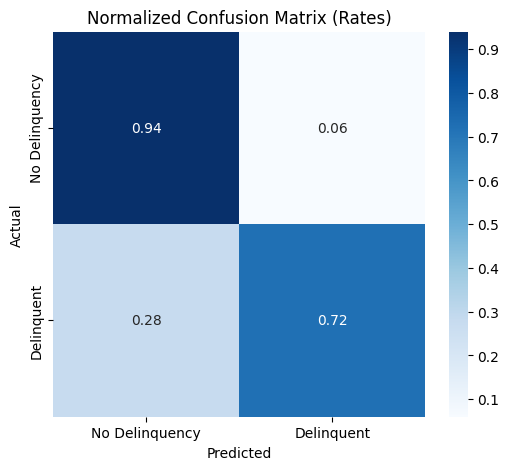

In [47]:
### Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
cm_rates = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rates, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["No Delinquency", "Delinquent"],
                yticklabels=["No Delinquency", "Delinquent"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix (Rates)")
plt.savefig(os.path.join(bookPath, "multimodal_confusion_matrix_crossattention.pdf"))

plt.show()

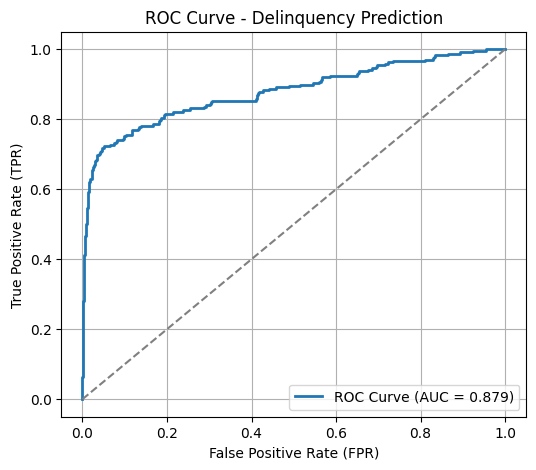

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9929    0.9401    0.9657      9762
         1.0     0.2272    0.7227    0.3457       238

    accuracy                         0.9349     10000
   macro avg     0.6100    0.8314    0.6557     10000
weighted avg     0.9746    0.9349    0.9510     10000



In [48]:
### ROC Curve & AUC Score
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal reference line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Delinquency Prediction")
plt.legend(loc=4)
plt.grid()
plt.savefig(os.path.join(bookPath, "multimodal_roc_curve_crossattention.pdf"))

plt.show()

### Classification Report
print("Classification Report:\n", classification_report(all_labels, all_preds, digits=4))

We observe an improvement in the ROC AUC score.